In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import json

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [64]:
# Define dataset paths
train_dir = "processed_dataset_split/train"
val_dir = "processed_dataset_split/val"
test_dir = "processed_dataset_split/test"

# Define transformations with additional augmentations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # ✅ Convert to Tensor FIRST
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # ✅ Normalize after ToTensor
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])

# Load dataset
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(train_dataset.transform)  # Should print the transform pipeline


Compose(
    Grayscale(num_output_channels=3)
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    RandomAffine(degrees=[0.0, 0.0], translate=(0.1, 0.1))
    RandomPerspective(p=0.5)
    RandomErasing(p=0.3, scale=(0.02, 0.2), ratio=(0.3, 3.3), value=0, inplace=False)
    ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1))
)


In [65]:
image, label = train_dataset[0]  # Get a sample image
print(type(image))  # Should be <class 'torch.Tensor'>
print(image.shape)  # Should be (3, 224, 224) (for RGB 3 channels)

<class 'torch.Tensor'>
torch.Size([3, 224, 224])


In [66]:
# Define loss function
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_labels = ["Low Corrosion", "Moderate Corrosion", "Severe Corrosion"]
all_labels = [label for _, label in train_dataset.samples]  # Get all labels
computed_weights = compute_class_weight("balanced", classes=np.unique(all_labels), y=all_labels)
class_weights = torch.tensor(computed_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [75]:
import json

# Function to train a model
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, model_name, epochs):
    best_loss = float("inf")
    patience_counter = 0  # Counter for early stopping

    # Define history dictionary
    history = {"train_acc": [], "train_loss": [], "val_acc": [], "val_loss": []}

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100.0 * correct / total
        train_loss = running_loss / len(train_loader)

        history["train_acc"].append(train_acc)
        history["train_loss"].append(train_loss)

        print(f"{model_name} - Epoch {epoch+1}: Loss={train_loss:.4f}, Train Acc={train_acc:.2f}%")
        scheduler.step(train_loss)

        # Validation Phase (Move before checking best loss)
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_acc = 100.0 * correct / total
        val_loss /= len(val_loader)

        print(f"Validation - Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

        history["val_acc"].append(val_acc)
        history["val_loss"].append(val_loss)

        # Early stopping based on validation loss
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), f"{model_name}.pth")
            patience_counter = 0  # Reset patience counter
        else:
            patience_counter += 1  # Increase if no improvement

        if patience_counter > 15:
            print("Early stopping triggered.")
            break

    # Save history after training
    with open(f"{model_name}_history.json", "w") as f:
        json.dump(history, f, indent=4)


In [76]:
# Train Baseline Model (Feature Extraction)
baseline_model = models.resnet50(pretrained=True)
for param in baseline_model.parameters():
    param.requires_grad = False  # Freeze all layers
num_ftrs = baseline_model.fc.in_features
baseline_model.fc = nn.Linear(num_ftrs, 3)
baseline_model = baseline_model.to(device)
optimizer_baseline = optim.Adam(baseline_model.fc.parameters(), lr=0.001)
scheduler_baseline = optim.lr_scheduler.ReduceLROnPlateau(optimizer_baseline, mode='min', factor=0.5, patience=3, verbose=True)

train_model(baseline_model, criterion, optimizer_baseline, scheduler_baseline, train_loader, val_loader, "resnet50_baseline", epochs=50)

D:\01_PROJECTS\SEMClassify\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\01_PROJECTS\SEMClassify\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


resnet50_baseline - Epoch 1: Loss=1.2082, Train Acc=39.33%
Validation - Loss: 1.3810, Acc: 41.67%
resnet50_baseline - Epoch 2: Loss=1.1471, Train Acc=37.08%
Validation - Loss: 1.0809, Acc: 33.33%
resnet50_baseline - Epoch 3: Loss=1.0929, Train Acc=43.82%
Validation - Loss: 1.1547, Acc: 50.00%
resnet50_baseline - Epoch 4: Loss=1.0042, Train Acc=47.19%
Validation - Loss: 1.0342, Acc: 41.67%
resnet50_baseline - Epoch 5: Loss=0.9935, Train Acc=51.69%
Validation - Loss: 0.8578, Acc: 75.00%
resnet50_baseline - Epoch 6: Loss=0.9669, Train Acc=53.93%
Validation - Loss: 0.8684, Acc: 66.67%
resnet50_baseline - Epoch 7: Loss=1.0060, Train Acc=47.19%
Validation - Loss: 0.9602, Acc: 58.33%
resnet50_baseline - Epoch 8: Loss=1.0176, Train Acc=44.94%
Validation - Loss: 0.8656, Acc: 66.67%
resnet50_baseline - Epoch 9: Loss=0.8734, Train Acc=60.67%
Validation - Loss: 0.9837, Acc: 41.67%
resnet50_baseline - Epoch 10: Loss=0.8998, Train Acc=65.17%
Validation - Loss: 0.9801, Acc: 41.67%
resnet50_baseline -

In [77]:
# Train Fine-Tuned Model (Last 50 layers trainable)
fine_tuned_model = models.resnet50(pretrained=True)
for param in fine_tuned_model.parameters():
    param.requires_grad = False

for param in list(fine_tuned_model.parameters())[-20:]:
    param.requires_grad = True

num_ftrs = fine_tuned_model.fc.in_features

fine_tuned_model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 3)
)

fine_tuned_model = fine_tuned_model.to(device)
optimizer_finetuned = optim.Adam(filter(lambda p: p.requires_grad, fine_tuned_model.parameters()), lr=0.0001)
scheduler_finetuned = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_finetuned, mode='min', factor=0.5, patience=5, verbose=True
)


train_model(fine_tuned_model, criterion, optimizer_finetuned, scheduler_finetuned, train_loader, val_loader, "resnet50_finetuned", epochs=50)

print("Training complete for both models.")

resnet50_finetuned - Epoch 1: Loss=1.1217, Train Acc=37.08%
Validation - Loss: 1.1072, Acc: 50.00%
resnet50_finetuned - Epoch 2: Loss=1.0460, Train Acc=41.57%
Validation - Loss: 1.0321, Acc: 50.00%
resnet50_finetuned - Epoch 3: Loss=0.9768, Train Acc=55.06%
Validation - Loss: 0.9581, Acc: 58.33%
resnet50_finetuned - Epoch 4: Loss=0.9373, Train Acc=55.06%
Validation - Loss: 0.8342, Acc: 58.33%
resnet50_finetuned - Epoch 5: Loss=0.8936, Train Acc=53.93%
Validation - Loss: 0.7727, Acc: 75.00%
resnet50_finetuned - Epoch 6: Loss=0.7676, Train Acc=70.79%
Validation - Loss: 0.8909, Acc: 50.00%
resnet50_finetuned - Epoch 7: Loss=0.8543, Train Acc=64.04%
Validation - Loss: 0.8715, Acc: 58.33%
resnet50_finetuned - Epoch 8: Loss=0.7877, Train Acc=65.17%
Validation - Loss: 0.6447, Acc: 75.00%
resnet50_finetuned - Epoch 9: Loss=0.7046, Train Acc=70.79%
Validation - Loss: 0.8532, Acc: 58.33%
resnet50_finetuned - Epoch 10: Loss=0.7696, Train Acc=68.54%
Validation - Loss: 1.1161, Acc: 50.00%
resnet50_


Model Performance on Test Set:
Accuracy: 50.00%
Precision: 63.54%
Recall: 50.00%
F1-Score: 47.46%


<Figure size 600x500 with 0 Axes>

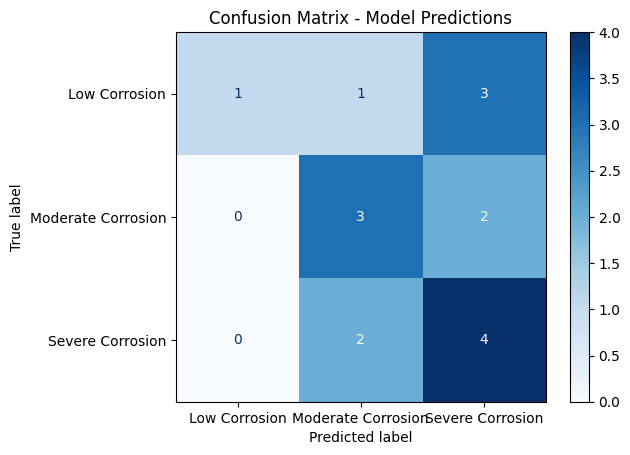

50.0

In [80]:
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute classification metrics
    accuracy = accuracy_score(all_labels, all_preds) * 100
    precision = precision_score(all_labels, all_preds, average="weighted") * 100
    recall = recall_score(all_labels, all_preds, average="weighted") * 100
    f1 = f1_score(all_labels, all_preds, average="weighted") * 100

    # Print results
    print(f"\nModel Performance on Test Set:")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.2f}%")
    print(f"Recall: {recall:.2f}%")
    print(f"F1-Score: {f1:.2f}%")

    # Generate Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low Corrosion", "Moderate Corrosion", "Severe Corrosion"])

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix - Model Predictions")
    plt.show()

    return accuracy

# Run evaluation after training
evaluate_model(fine_tuned_model, test_loader)

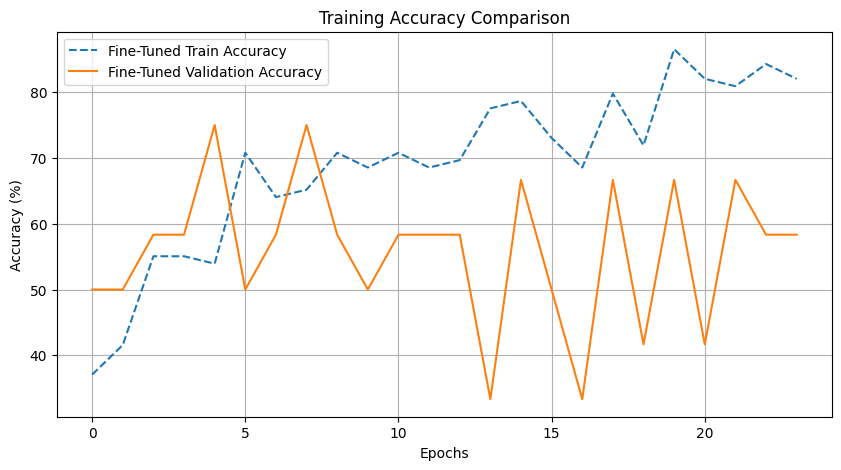

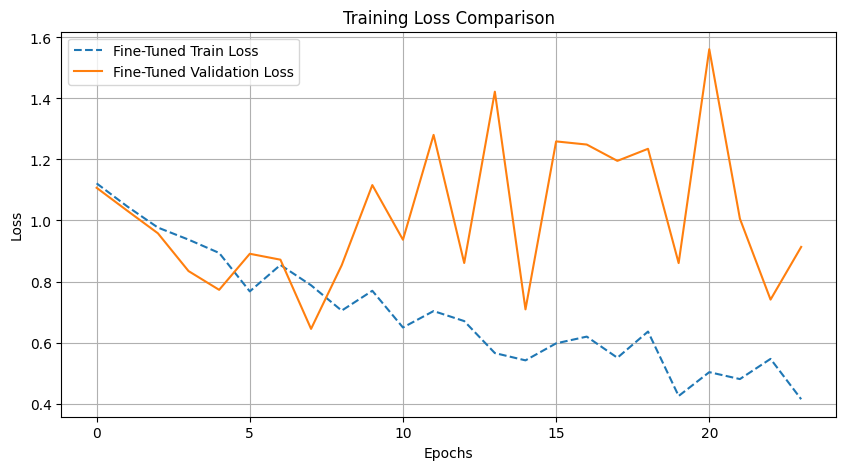

In [81]:
def plot_training_history(finetuned_file):
    import json
    import matplotlib.pyplot as plt

    with open(finetuned_file, "r") as f:
        finetuned_history = json.load(f)

    # Plot Training Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(finetuned_history["train_acc"], label="Fine-Tuned Train Accuracy", linestyle='dashed')
    plt.plot(finetuned_history["val_acc"], label="Fine-Tuned Validation Accuracy")

    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Training Accuracy Comparison")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Training Loss
    plt.figure(figsize=(10, 5))
    plt.plot(finetuned_history["train_loss"], label="Fine-Tuned Train Loss", linestyle='dashed')
    plt.plot(finetuned_history["val_loss"], label="Fine-Tuned Validation Loss")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Comparison")
    plt.legend()
    plt.grid()
    plt.show()

# Call function to plot history after training
plot_training_history("resnet50_finetuned_history.json")